# Heart Disease Parameters
## UCI Heart Data Set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Reading file
path_to_file = "/content/drive/My Drive/anotherHeart.csv" 

import csv

data = []
with open(path_to_file, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',') # csv.DictReader(csv_file)
    for row in csv_reader:
      data.append(row)

# Split title and data
trainingData = data[1:]
fakeTitle = data[:1]
title = fakeTitle[0]
print(title)

['\ufeffage', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [3]:
# Randomly shuffle the data
import numpy as np
x = np.array(trainingData)
np.random.shuffle(x)
print(np.shape(x))

(303, 14)


In [4]:
# A bunch of imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook

In [5]:
# Split training set and testing set
# Size: 1025, trainingSet: 80%, testingSet: 20%
trainingSet = x[:250]
testingSet = x[250:]
print(np.shape(trainingSet))
print(np.shape(testingSet))

(250, 14)
(53, 14)


In [6]:
# Split input and output for training set
trainingInput = trainingSet[:,:13]
trainingOutput = trainingSet[:,13]
trainingInput = trainingInput.astype(np.float)
trainingOutput = trainingOutput.astype(np.float)
trainingOutput = torch.from_numpy(trainingOutput).float().reshape(-1,1)
print(np.shape(trainingOutput))
print(np.shape(trainingInput))

torch.Size([250, 1])
(250, 13)


In [19]:
trainingFeatureNames = title[:-1] # TODO: Are we ending on index 12?
inData = {}
normalizationConstant = {}
for i, feature in enumerate(trainingFeatureNames):
  inData[i] = torch.from_numpy(trainingInput[:,i]).float().reshape(-1,1) # Can do by feature name or index
for i in inData:
  normalizationConstant[i] = torch.max(inData[i])
  inData[i] = inData[i] / normalizationConstant[i] # normalization 
print(np.shape(inData[12]))

torch.Size([250, 1])


In [20]:
# Create Net class
class Net(nn.Module):
  def __init__(self, layerWidth=300):
    super(Net, self).__init__();
    self.fc1 = nn.Linear(1, layerWidth)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(layerWidth, layerWidth)
    nn.init.kaiming_normal_(self.fc2.weight)
    self.fc3 = nn.Linear(layerWidth, layerWidth)
    nn.init.kaiming_normal_(self.fc3.weight)
    self.fc4 = nn.Linear(layerWidth,1)
    nn.init.kaiming_normal_(self.fc4.weight)
  def forward (self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [21]:
nets = []
for i in range(13):
  nets.append( Net() )

In [22]:
import torch.optim as optim
from tqdm import tqdm_notebook

optimizers = [optim.Adam(nets[i].parameters()) for i in range(len(nets))]

epochs = tqdm_notebook(range(2500))
criterion = nn.MSELoss()
for epoch in epochs:
  for optimizer in optimizers:
    optimizer.zero_grad()

  outputs = [nets[i](inData[i]) for i in range(len(nets))]

  totalOut = sum(outputs) # TODO: Check that this works.
  loss = criterion(totalOut,trainingOutput)
  loss.backward()

  for optimizer in optimizers:
    optimizer.step()

  epochs.set_description(str(loss.data.item()))

print(loss.data.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



0.0833517462015152


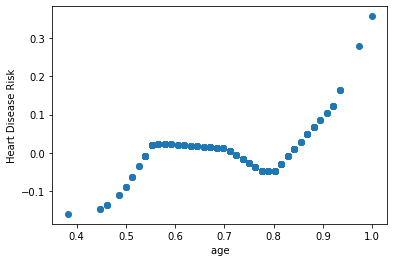

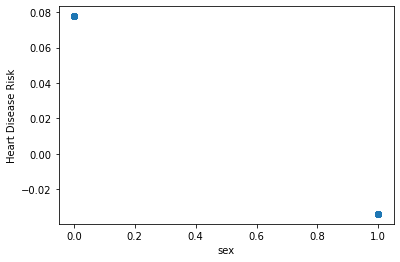

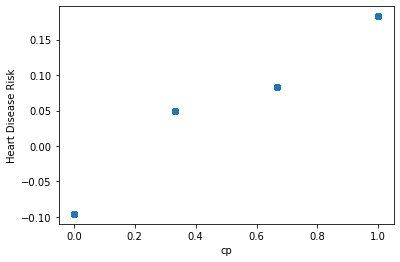

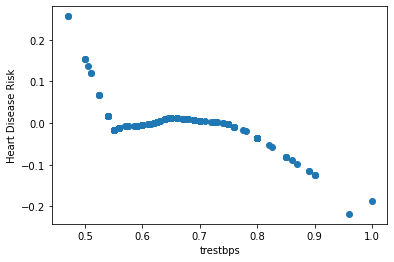

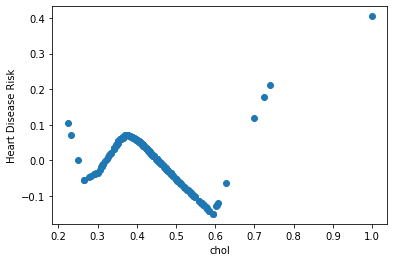

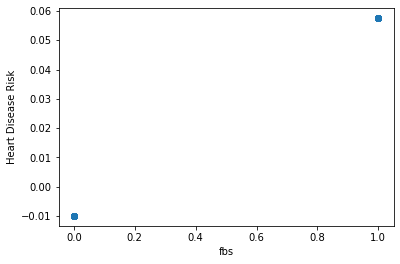

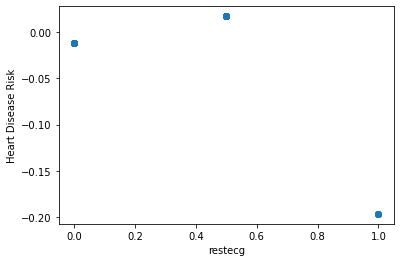

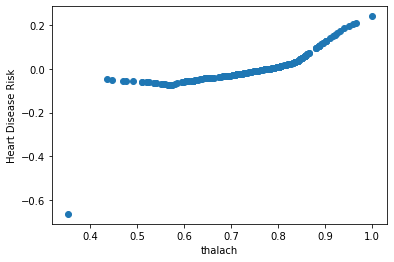

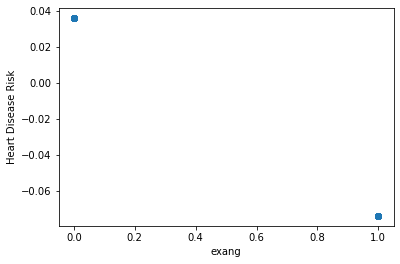

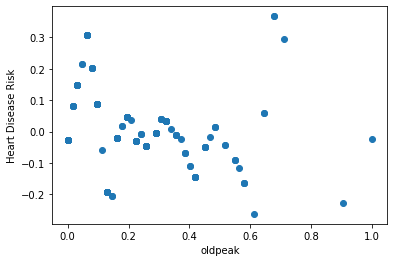

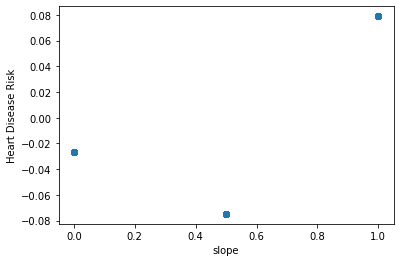

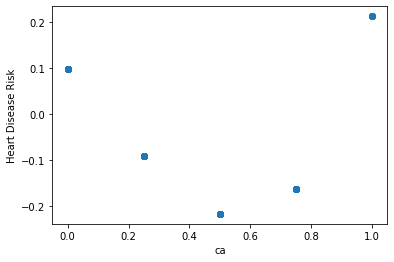

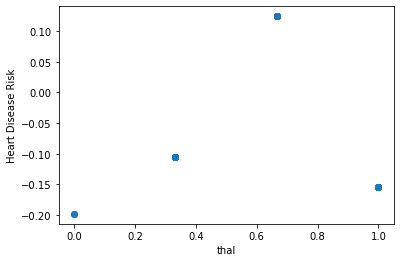

0.5850150124169886


In [24]:
def plotFeatureFunction(featureIndex):
  newOutput = outputs[featureIndex].detach().numpy()
  # newOutput = newOutput - (np.max(newOutput) + np.min(newOutput))/2
  meanOutput = np.mean(newOutput)
  newOutput = newOutput - meanOutput
  plt.scatter(inData[featureIndex], newOutput)
  plt.xlabel(trainingFeatureNames[featureIndex])
  plt.ylabel("Heart Disease Risk")
  plt.show()
  return meanOutput

scoreOffSet = 0

for i in range(len(nets)):
  # plotFeatureFunction(i)
  scoreOffSet = scoreOffSet + plotFeatureFunction(i)
print(scoreOffSet)

## Testing

In [26]:
testingInput = testingSet[:,:13]
testingOutput = testingSet[:,13]
testingInput = testingInput.astype(np.float)
testingOutput = testingOutput.astype(np.float)
trainingFeatureNames = title[:-1] # TODO: Are we ending on index 12?
testData = {}
for i, feature in enumerate(trainingFeatureNames):
  testData[i] = torch.from_numpy(testingInput[:,i]).float().reshape(-1,1) # Can do by feature name or index
for i in testData:
  testData[i] = testData[i] / normalizationConstant[i] # normalization 

print(testingOutput)

[0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 1. 1.]


In [27]:
totalOutNp = totalOut.detach().numpy()
totalOutNp = totalOutNp - 0.5
finalOut = np.ceil(totalOutNp).astype(np.int)
trainingOutputNp = trainingOutput.detach().numpy()
totalCorrect = 0
totalPoints =  trainingOutputNp.size
for i in range(totalPoints):
  if(finalOut[i] == trainingOutputNp[i]):
    totalCorrect += 1
print(totalCorrect/totalPoints)

0.912


In [28]:
prediction = [nets[i](testData[i]) for i in range(len(nets))]
totalOut = sum(prediction)
print(totalOut)

tensor([[-0.0644],
        [ 0.9165],
        [ 0.8545],
        [ 0.7667],
        [-0.0146],
        [ 0.9069],
        [ 1.0346],
        [ 0.6411],
        [ 1.0618],
        [ 0.5942],
        [ 0.9019],
        [ 0.5958],
        [ 0.7664],
        [ 0.5794],
        [ 0.2898],
        [ 0.6395],
        [ 0.9542],
        [ 0.5754],
        [ 0.6883],
        [ 0.6589],
        [ 0.8849],
        [ 0.8675],
        [ 0.1457],
        [ 0.3023],
        [ 0.8950],
        [-0.1820],
        [ 0.3632],
        [ 0.7044],
        [ 0.2952],
        [ 0.1951],
        [ 0.5556],
        [ 1.0187],
        [ 1.0507],
        [ 0.6171],
        [ 0.3142],
        [ 0.7174],
        [-0.2793],
        [ 1.1396],
        [ 0.4487],
        [ 0.5021],
        [ 0.8176],
        [ 0.7527],
        [ 0.8589],
        [ 0.2258],
        [ 0.8045],
        [ 0.1156],
        [ 0.0543],
        [ 0.6196],
        [ 0.6986],
        [ 1.0520],
        [-0.0133],
        [ 0.8470],
        [ 0.

In [ ]:
ageOut = net0(ageIn)
sexOut = net1(sexIn)
cpOut = net2(cpIn)
bpsOut = net3(bpsIn)
cholOut = net4(cholIn)
fbsOut = net5(fbsIn)
ecgOut = net6(ecgIn)
maxOut = net7(maxIn)
exangOut = net8(exangIn)
oldpeakOut = net9(oldpeakIn)
slopeOut = net10(slopeIn)
caOut = net11(caIn)
thalOut = net12(thalIn)

totalOut = ageOut + sexOut + cpOut + bpsOut + cholOut + fbsOut + ecgOut + maxOut + exangOut + oldpeakOut + slopeOut + caOut + thalOut

In [29]:
totalOutNp = totalOut.detach().numpy()
totalOutNp = totalOutNp - 0.5
finalOut = np.ceil(totalOutNp).astype(np.int)
# testingOutputNp = testingOutput.detach().numpy()
totalCorrect = 0
totalPoints = totalOutNp.size
for i in range(totalPoints):
  if(finalOut[i] == testingOutput[i]):
    totalCorrect += 1
print(totalCorrect/totalPoints)

0.7735849056603774
